In [1]:
import sys
sys.path.append("../src")
sys.path.append("../data/embeddings")
import classifier
import debias
#import debias_old as debias
import gensim
import codecs
import json
from gensim.models.keyedvectors import Word2VecKeyedVectors
from gensim.models import KeyedVectors
import numpy as np
import random
import sklearn
from sklearn import model_selection
from sklearn import cluster
from sklearn import metrics
from sklearn.manifold import TSNE
from sklearn.svm import LinearSVC, SVC
from sklearn.linear_model import SGDClassifier, Perceptron, LogisticRegression, PassiveAggressiveClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
import scipy
from scipy import linalg
from scipy.stats.stats import pearsonr
import tqdm
import matplotlib
import matplotlib.pyplot as plt
# %matplotlib inline
# matplotlib.rcParams['agg.path.chunksize'] = 10000
from sklearn.utils import shuffle

# import warnings
# warnings.filterwarnings("ignore")
# %load_ext autoreload
# %autoreload

from collections import Counter, defaultdict
import seaborn as sns
# sns.set_style("whitegrid")

# Function

In [2]:
def load_data(path, size, ratio=0.5):
    fnames = ["neg_neg.npy", "neg_pos.npy", "pos_neg.npy", "pos_pos.npy"]
    protected_labels = [0, 1, 0, 1]
    main_labels = [0, 0, 1, 1]
    X, Y_p, Y_m = [], [], []
    n1 = int(size * ratio / 2)
    n2 = int(size * (1 - ratio) / 2)
#     print(n1, n2)

    for fname, p_label, m_label, n in zip(fnames, protected_labels, main_labels, [n1, n2, n2, n1]):
#         print(path + '/' + fname)
#         print(np.load(path + '/' + fname).shape)
        data = np.load(path + '/' + fname)[:n]
        for x in data:
            X.append(x)
        for _ in data:
            Y_p.append(p_label)
        for _ in data:
            Y_m.append(m_label)

    Y_p = np.array(Y_p)
    Y_m = np.array(Y_m)
    X = np.array(X)
    X, Y_p, Y_m = shuffle(X, Y_p, Y_m, random_state=0)
    return X, Y_p, Y_m

In [3]:
def get_TPR(y_main, y_hat_main, y_protected):
    
    all_y = list(Counter(y_main).keys())
    
    protected_vals = defaultdict(dict)
    for label in all_y:
        for i in range(2):
            used_vals = (y_main == label) & (y_protected == i)
            y_label = y_main[used_vals]
            y_hat_label = y_hat_main[used_vals]
            protected_vals['y:{}'.format(label)]['p:{}'.format(i)] = (y_label == y_hat_label).mean()
            
    diffs = {}
    for k, v in protected_vals.items():
        vals = list(v.values())
        diffs[k] = vals[0] - vals[1]
    return protected_vals, diffs

In [4]:
def rms(arr):
    return np.sqrt(np.mean(np.square(arr)))

In [5]:
def calc_plot_tpr(P):
    
    results = defaultdict(dict)
    for ratio in [0.5, 0.6, 0.7, 0.8]:

        x_train, y_p_train, y_m_train = load_data(
            '../data/emoji_sent_race_{}/train/'.format(ratio),
            size=100000, ratio=ratio)
        x_dev, y_p_dev, y_m_dev = load_data(
            '../data/emoji_sent_race_{}/test/'.format(ratio),
            size=100000, ratio=0.5)

        biased_classifier = LinearSVC(fit_intercept=True, class_weight='balanced', dual=False, C=0.1, max_iter=10000)

        biased_classifier.fit(x_train, y_m_train)
        biased_score = biased_classifier.score(x_dev, y_m_dev)

    #     P = np.load('../data/emoji_sent_race_{}/P_svm.num-clfs=300.npy'.format(ratio), allow_pickle=True)
    #     P = P[1]

    #     n_dims = 120
    # #     n_dims = 70
    #     if ratio == 0.5:
    #         n_dims = 200
    #     elif ratio == 0.6:
    #         n_dims = 100
    #     elif ratio == 0.7:
    #         n_dims = 115
    #     elif ratio == 0.8:
    #         n_dims = 200

    #     P = debias.get_projection_to_intersection_of_nullspaces(P[:n_dims], input_dim=300)

        debiased_x_train = P.dot(x_train.T).T
        debiased_x_dev = P.dot(x_dev.T).T

        classifier = LinearSVC(fit_intercept=True, class_weight='balanced', dual=False, C=0.1, max_iter=10000)

        classifier.fit(debiased_x_train, y_m_train)
        debiased_score = classifier.score(debiased_x_dev, y_m_dev)

        p_classifier = SGDClassifier(warm_start=True, loss='log', n_jobs=64, max_iter=10000, random_state=0, tol=1e-3)
        p_classifier.fit(debiased_x_train, y_p_train)
        p_score = p_classifier.score(debiased_x_dev, y_p_dev)
        results[ratio]['p_acc'] = p_score

        _, biased_diffs = get_TPR(y_m_dev, biased_classifier.predict(x_dev), y_p_dev)

        _, debiased_diffs = get_TPR(y_m_dev, classifier.predict(debiased_x_dev), y_p_dev)

    #     results[ratio]['biased_diff_tpr'] = biased_diffs['y:0']
        results[ratio]['biased_diff_tpr'] = rms(list(biased_diffs.values()))
    #     results[ratio]['debiased_diff_tpr'] = debiased_diffs['y:0']
        results[ratio]['debiased_diff_tpr'] = rms(list(debiased_diffs.values()))

        results[ratio]['biased_acc'] = biased_score
        results[ratio]['debiased_acc'] = debiased_score

    plot_results = defaultdict(list)
    for r in [0.5, 0.6, 0.7, 0.8]:
        plot_results['biased_diff_tpr'].append(results[r]['biased_diff_tpr'])
        plot_results['debiased_diff_tpr'].append(results[r]['debiased_diff_tpr'])
        plot_results['biased_acc'].append(results[r]['biased_acc'])
        plot_results['debiased_acc'].append(results[r]['debiased_acc'])

    return results, plot_results

In [6]:
def data2plot(results, removal_range):
    x = removal_range

    fig, ax1 = plt.subplots()

    color = 'tab:red'
    ax1.set_xlabel('ratio')
    ax1.set_ylabel('diff tpr', color=color)
    ax1.plot(x, results['biased_diff_tpr'], '.--', label='biased tpr diff', color=color)
    ax1.plot(x, results['debiased_diff_tpr'], '*:', label='debiased tpr diff', color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    plt.ylim(0.,0.6)

    ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

    color = 'tab:blue'
    ax2.set_ylabel('acc', color=color)  # we already handled the x-label with ax1
    ax2.plot(x, results['biased_acc'], '^-', label='biased acc', color=color)
    ax2.plot(x, results['debiased_acc'], 'o--', label='debiased acc', color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    # ask matplotlib for the plotted objects and their labels
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax2.legend(lines, labels, loc='lower right')
    
    from matplotlib.legend import Legend
    leg = Legend(ax2, lines2, labels2,
             loc='upper left', frameon=False)
    ax2.add_artist(leg);

    plt.title('TPR rates as a function of the ratio')
    plt.ylim(0.5,.85)
#     plt.legend()
#     plt.savefig('tpr_rates_ratio.png', dpi=1000)
    plt.show()
    
# data2plot(plot_results)

# Cross-validate

In [7]:
def check_result(u, removel_range, x_train, x_dev, y_m_train, y_m_dev, y_p_train, y_p_dev):
    results = defaultdict(dict)

    biased_classifier = LinearSVC(fit_intercept=True, class_weight='balanced', dual=False, C=0.1, max_iter=10000)

    biased_classifier.fit(x_train, y_m_train)
    biased_score = biased_classifier.score(x_dev, y_m_dev)
    _, biased_diffs = get_TPR(y_m_dev, biased_classifier.predict(x_dev), y_p_dev)
    
    for removal in removel_range:
        u_r = u[:, removal:]
        proj = u_r @ u_r.T
        P = proj

        debiased_x_train = P.dot(x_train.T).T
        debiased_x_dev = P.dot(x_dev.T).T

        classifier = LinearSVC(fit_intercept=True, class_weight='balanced', dual=False, C=0.1, max_iter=10000)

        classifier.fit(debiased_x_train, y_m_train)
        debiased_score = classifier.score(debiased_x_dev, y_m_dev)

        p_classifier = SGDClassifier(warm_start=True, loss='log', n_jobs=64, max_iter=10000, random_state=0, tol=1e-3)
        p_classifier.fit(debiased_x_train, y_p_train)
        p_score = p_classifier.score(debiased_x_dev, y_p_dev)

        _, debiased_diffs = get_TPR(y_m_dev, classifier.predict(debiased_x_dev), y_p_dev)


        results[removal]['p_acc'] = p_score
        #     results[ratio]['biased_diff_tpr'] = biased_diffs['y:0']
        results[removal]['biased_diff_tpr'] = rms(list(biased_diffs.values()))
        #     results[ratio]['debiased_diff_tpr'] = debiased_diffs['y:0']
        results[removal]['debiased_diff_tpr'] = rms(list(debiased_diffs.values()))

        results[removal]['biased_acc'] = biased_score
        results[removal]['debiased_acc'] = debiased_score
        
    return results

In [8]:
def check_result_ksvd(W, K_x_sqrt2, U_Kx, K_x_dv_sqrt2, U_Kx_dv, removel_range, x_train, x_dev, y_m_train, y_m_dev, y_p_train, y_p_dev):
    results = defaultdict(dict)

    biased_classifier = LinearSVC(fit_intercept=True, class_weight='balanced', dual=False, C=0.1, max_iter=10000)

    biased_classifier.fit(x_train, y_m_train)
    biased_score = biased_classifier.score(x_dev, y_m_dev)
    _, biased_diffs = get_TPR(y_m_dev, biased_classifier.predict(x_dev), y_p_dev)
    
    for removal in removel_range:
        W2 = W[:, :removal]
        Wprime = W2
        U_proj_ker = linalg.null_space((K_x_sqrt2 @ Wprime).T)
        
        debiased_x_train = (U_proj_ker.T @ K_x_sqrt2).T
        debiased_x_dev = (U_proj_ker.T @ U_Kx  @ U_Kx_dv.T @ K_x_dv_sqrt2).T

        classifier = LinearSVC(fit_intercept=True, class_weight='balanced', dual=False, C=0.1, max_iter=10000)

        classifier.fit(debiased_x_train, y_m_train)
        debiased_score = classifier.score(debiased_x_dev, y_m_dev)

        p_classifier = SGDClassifier(warm_start=True, loss='log', n_jobs=64, max_iter=10000, random_state=0, tol=1e-3)
        p_classifier.fit(debiased_x_train, y_p_train)
        p_score = p_classifier.score(debiased_x_dev, y_p_dev)

        _, debiased_diffs = get_TPR(y_m_dev, classifier.predict(debiased_x_dev), y_p_dev)


        results[removal]['p_acc'] = p_score
        #     results[ratio]['biased_diff_tpr'] = biased_diffs['y:0']
        results[removal]['biased_diff_tpr'] = rms(list(biased_diffs.values()))
        #     results[ratio]['debiased_diff_tpr'] = debiased_diffs['y:0']
        results[removal]['debiased_diff_tpr'] = rms(list(debiased_diffs.values()))

        results[removal]['biased_acc'] = biased_score
        results[removal]['debiased_acc'] = debiased_score
        
    return results

In [9]:
def convert_to_plot_results(results, removel_range):
    plot_results = defaultdict(list)
    for r in removel_range:
        plot_results['biased_diff_tpr'].append(results[r]['biased_diff_tpr'])
        plot_results['debiased_diff_tpr'].append(results[r]['debiased_diff_tpr'])
        plot_results['biased_acc'].append(results[r]['biased_acc'])
        plot_results['debiased_acc'].append(results[r]['debiased_acc'])
    return plot_results

In [9]:
# ratio = 0.5

# x_train, y_p_train, y_m_train = load_data(
#     '../data/emoji_sent_race_{}/train/'.format(ratio),
#     size=100000, ratio=ratio)
# x_dev, y_p_dev, y_m_dev = load_data(
#     '../data/emoji_sent_race_{}/test/'.format(ratio),
#     size=100000, ratio=0.5)
# np.savetxt(f"../data/saved_models/fair_emoji_sent_race/{ratio}/x_train.csv", x_train, delimiter=",")
# np.savetxt(f"../data/saved_models/fair_emoji_sent_race/{ratio}/y_p_train.csv", y_p_train, delimiter=",")
# np.savetxt(f"../data/saved_models/fair_emoji_sent_race/{ratio}/y_m_train.csv", y_m_train, delimiter=",")
# np.savetxt(f"../data/saved_models/fair_emoji_sent_race/{ratio}/x_dev.csv", x_dev, delimiter=",")
# np.savetxt(f"../data/saved_models/fair_emoji_sent_race/{ratio}/y_p_dev.csv", y_p_dev, delimiter=",")
# np.savetxt(f"../data/saved_models/fair_emoji_sent_race/{ratio}/y_m_dev.csv", y_m_dev, delimiter=",")
# np.savez(f"../data/saved_models/fair_emoji_sent_race/{ratio}/all.npz", x_train = x_train, y_p_train = y_p_train, y_m_train = y_m_train, x_dev = x_dev, y_p_dev = y_p_dev, y_m_dev = y_m_dev)

# Null it out

In [10]:
# ratio = 0.5

# saved_dataset = np.load(f"../data/saved_models/fair_emoji_sent_race/{ratio}/all.npz")

# x_train = saved_dataset['x_train']
# y_m_train = saved_dataset['y_m_train']
# y_p_train = saved_dataset['y_p_train']

# x_dev = saved_dataset['x_dev']
# y_p_dev = saved_dataset['y_p_dev']
# y_m_dev = saved_dataset['y_m_dev']

In [10]:
for ratio in [0.5, 0.6, 0.7, 0.8]:

#     x_train, y_p_train, y_m_train = load_data(
#         '../data/emoji_sent_race_{}/train/'.format(ratio),
#         size=100000, ratio=ratio)
#     x_dev, y_p_dev, y_m_dev = load_data(
#         '../data/emoji_sent_race_{}/test/'.format(ratio),
#         size=100000, ratio=0.5)
    saved_dataset = np.load(f"../data/saved_models/fair_emoji_sent_race/{ratio}/all.npz")

    x_train = saved_dataset['x_train']
    y_m_train = saved_dataset['y_m_train']
    y_p_train = saved_dataset['y_p_train']

    x_dev = saved_dataset['x_dev']
    y_p_dev = saved_dataset['y_p_dev']
    y_m_dev = saved_dataset['y_m_dev']
    
    print(f"ratio = {ratio}, train size {x_train.shape}, dev size {x_dev.shape}\n\n\n")

ratio = 0.5, train size (100000, 300), dev size (7998, 300)



ratio = 0.6, train size (100000, 300), dev size (7998, 300)



ratio = 0.7, train size (100000, 300), dev size (7998, 300)



ratio = 0.8, train size (99998, 300), dev size (7998, 300)





In [12]:
results = defaultdict(dict)

for ratio in [0.5, 0.6, 0.7, 0.8]:

#     x_train, y_p_train, y_m_train = load_data(
#         '../data/emoji_sent_race_{}/train/'.format(ratio),
#         size=100000, ratio=ratio)
#     x_dev, y_p_dev, y_m_dev = load_data(
#         '../data/emoji_sent_race_{}/test/'.format(ratio),
#         size=100000, ratio=0.5)
    saved_dataset = np.load(f"../data/saved_models/fair_emoji_sent_race/{ratio}/all.npz")

    x_train = saved_dataset['x_train']
    y_m_train = saved_dataset['y_m_train']
    y_p_train = saved_dataset['y_p_train']

    x_dev = saved_dataset['x_dev']
    y_p_dev = saved_dataset['y_p_dev']
    y_m_dev = saved_dataset['y_m_dev']
    
    biased_classifier = LinearSVC(fit_intercept=True, class_weight='balanced', dual=False, C=0.1, max_iter=10000)

    biased_classifier.fit(x_train, y_m_train)
    biased_score = biased_classifier.score(x_dev, y_m_dev)
    
    P = np.load('../data/emoji_sent_race_{}/P_svm.num-clfs=300.npy'.format(ratio), allow_pickle=True)
    P = P[1]
    n_dims = 120
#     n_dims = 70
    if ratio == 0.5:
        n_dims = 200
    elif ratio == 0.6:
        n_dims = 100
    elif ratio == 0.7:
        n_dims = 115
    elif ratio == 0.8:
        n_dims = 200
    P = debias.get_projection_to_intersection_of_nullspaces(P[:n_dims], input_dim=300)
    
    debiased_x_train = P.dot(x_train.T).T
    debiased_x_dev = P.dot(x_dev.T).T

    classifier = LinearSVC(fit_intercept=True, class_weight='balanced', dual=False, C=0.1, max_iter=10000)

    classifier.fit(debiased_x_train, y_m_train)
    debiased_score = classifier.score(debiased_x_dev, y_m_dev)
    
    p_classifier = SGDClassifier(warm_start=True, loss='log', n_jobs=64, max_iter=10000, random_state=0, tol=1e-3)
    p_classifier.fit(debiased_x_train, y_p_train)
    p_score = p_classifier.score(debiased_x_dev, y_p_dev)
    results[ratio]['p_acc'] = p_score
    
    _, biased_diffs = get_TPR(y_m_dev, biased_classifier.predict(x_dev), y_p_dev)
    
    _, debiased_diffs = get_TPR(y_m_dev, classifier.predict(debiased_x_dev), y_p_dev)
    
#     results[ratio]['biased_diff_tpr'] = biased_diffs['y:0']
    results[ratio]['biased_diff_tpr'] = rms(list(biased_diffs.values()))
#     results[ratio]['debiased_diff_tpr'] = debiased_diffs['y:0']
    results[ratio]['debiased_diff_tpr'] = rms(list(debiased_diffs.values()))
    
    results[ratio]['biased_acc'] = biased_score
    results[ratio]['debiased_acc'] = debiased_score

In [13]:
results

defaultdict(dict,
            {0.5: {'p_acc': 0.5396349087271818,
              'biased_diff_tpr': 0.14560632483708713,
              'debiased_diff_tpr': 0.11974302439852863,
              'biased_acc': 0.7653163290822705,
              'debiased_acc': 0.7625656414103525},
             0.6: {'p_acc': 0.5946486621655414,
              'biased_diff_tpr': 0.22630502371727185,
              'debiased_diff_tpr': 0.19067232927585404,
              'biased_acc': 0.7531882970742686,
              'debiased_acc': 0.7579394848712178},
             0.7: {'p_acc': 0.6257814453613403,
              'biased_diff_tpr': 0.31864557675474753,
              'debiased_diff_tpr': 0.26266284955843594,
              'biased_acc': 0.741185296324081,
              'debiased_acc': 0.7478119529882471},
             0.8: {'p_acc': 0.5043760940235059,
              'biased_diff_tpr': 0.4043010400370602,
              'debiased_diff_tpr': 0.010947167516829342,
              'biased_acc': 0.7200550137534384,
      

In [14]:
plot_results = defaultdict(list)
for r in [0.5, 0.6, 0.7, 0.8]:
    plot_results['biased_diff_tpr'].append(results[r]['biased_diff_tpr'])
    plot_results['debiased_diff_tpr'].append(results[r]['debiased_diff_tpr'])
    plot_results['biased_acc'].append(results[r]['biased_acc'])
    plot_results['debiased_acc'].append(results[r]['debiased_acc'])
plot_results

defaultdict(list,
            {'biased_diff_tpr': [0.14560632483708713,
              0.22630502371727185,
              0.31864557675474753,
              0.4043010400370602],
             'debiased_diff_tpr': [0.11974302439852863,
              0.19067232927585404,
              0.26266284955843594,
              0.010947167516829342],
             'biased_acc': [0.7653163290822705,
              0.7531882970742686,
              0.741185296324081,
              0.7200550137534384],
             'debiased_acc': [0.7625656414103525,
              0.7579394848712178,
              0.7478119529882471,
              0.5290072518129533]})

In [10]:
removel_range = [0, 1, 2, 5, 30, 50, 100, 200, 220, 240, 260, 280, 290, 295]

In [12]:
import time

In [13]:
ratio = 0.5

saved_dataset = np.load(f"../data/saved_models/fair_emoji_sent_race/{ratio}/all.npz")

x_train = saved_dataset['x_train']
y_m_train = saved_dataset['y_m_train']
y_p_train = saved_dataset['y_p_train']
y_p_train_2d = np.asarray([y_p_train, - y_p_train + 1]).T

x_dev = saved_dataset['x_dev']
y_p_dev = saved_dataset['y_p_dev']
y_m_dev = saved_dataset['y_m_dev']

t = time.time()
A = np.dot(x_train.T, y_p_train_2d) / x_train.shape[0]
u, s, vh = np.linalg.svd(A, full_matrices=True)
elapsed = time.time() - t
print(f"sal took {elapsed} seconds")
print(f"u has shape {u.shape}, s has shape {s.shape}, vh has shape {vh.shape}")

sal took 0.37548398971557617 seconds
u has shape (300, 300), s has shape (2,), vh has shape (2, 2)


In [26]:
results = check_result(u, removel_range, x_train, x_dev, y_m_train, y_m_dev, y_p_train, y_p_dev)
results

defaultdict(dict,
            {0: {'p_acc': 0.8714678669667417,
              'biased_diff_tpr': 0.14560632483708713,
              'debiased_diff_tpr': 0.14560632483708713,
              'biased_acc': 0.7653163290822705,
              'debiased_acc': 0.7653163290822705},
             1: {'p_acc': 0.8630907726931732,
              'biased_diff_tpr': 0.14560632483708713,
              'debiased_diff_tpr': 0.1445020833238553,
              'biased_acc': 0.7653163290822705,
              'debiased_acc': 0.7653163290822705},
             2: {'p_acc': 0.49699924981245314,
              'biased_diff_tpr': 0.14560632483708713,
              'debiased_diff_tpr': 0.11020173553336259,
              'biased_acc': 0.7653163290822705,
              'debiased_acc': 0.766816704176044},
             5: {'p_acc': 0.4959989997499375,
              'biased_diff_tpr': 0.14560632483708713,
              'debiased_diff_tpr': 0.11007656356661116,
              'biased_acc': 0.7653163290822705,
              

In [27]:
plot_results = convert_to_plot_results(results, removel_range)
plot_results

defaultdict(list,
            {'biased_diff_tpr': [0.14560632483708713,
              0.14560632483708713,
              0.14560632483708713,
              0.14560632483708713,
              0.14560632483708713,
              0.14560632483708713,
              0.14560632483708713,
              0.14560632483708713,
              0.14560632483708713,
              0.14560632483708713,
              0.14560632483708713,
              0.14560632483708713,
              0.14560632483708713,
              0.14560632483708713],
             'debiased_diff_tpr': [0.14560632483708713,
              0.1445020833238553,
              0.11020173553336259,
              0.11007656356661116,
              0.10621266898739956,
              0.10841554967602068,
              0.10844931019709282,
              0.1042793080915506,
              0.09987399516901178,
              0.1032924184615246,
              0.10346416206559751,
              0.1043429019092808,
              0.10178012864537783,


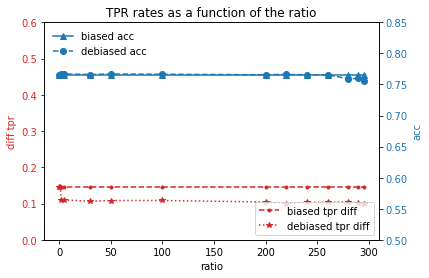

In [28]:
data2plot(plot_results, removel_range)

In [29]:
ratio = 0.6

saved_dataset = np.load(f"../data/saved_models/fair_emoji_sent_race/{ratio}/all.npz")

x_train = saved_dataset['x_train']
y_m_train = saved_dataset['y_m_train']
y_p_train = saved_dataset['y_p_train']
y_p_train_2d = np.asarray([y_p_train, - y_p_train + 1]).T

x_dev = saved_dataset['x_dev']
y_p_dev = saved_dataset['y_p_dev']
y_m_dev = saved_dataset['y_m_dev']

A = np.dot(x_train.T, y_p_train_2d) / x_train.shape[0]
u, s, vh = np.linalg.svd(A, full_matrices=True)
print(f"u has shape {u.shape}, s has shape {s.shape}, vh has shape {vh.shape}")

u has shape (300, 300), s has shape (2,), vh has shape (2, 2)


In [30]:
results = check_result(u, removel_range, x_train, x_dev, y_m_train, y_m_dev, y_p_train, y_p_dev)
results

defaultdict(dict,
            {0: {'p_acc': 0.840960240060015,
              'biased_diff_tpr': 0.22630502371727185,
              'debiased_diff_tpr': 0.22630502371727185,
              'biased_acc': 0.7531882970742686,
              'debiased_acc': 0.7531882970742686},
             1: {'p_acc': 0.8508377094273568,
              'biased_diff_tpr': 0.22630502371727185,
              'debiased_diff_tpr': 0.22803630357189353,
              'biased_acc': 0.7531882970742686,
              'debiased_acc': 0.7530632658164541},
             2: {'p_acc': 0.4711177794448612,
              'biased_diff_tpr': 0.22630502371727185,
              'debiased_diff_tpr': 0.08988024196274066,
              'biased_acc': 0.7531882970742686,
              'debiased_acc': 0.7531882970742686},
             5: {'p_acc': 0.4708677169292323,
              'biased_diff_tpr': 0.22630502371727185,
              'debiased_diff_tpr': 0.09037932830110916,
              'biased_acc': 0.7531882970742686,
              

In [31]:
plot_results = convert_to_plot_results(results, removel_range)
plot_results

defaultdict(list,
            {'biased_diff_tpr': [0.22630502371727185,
              0.22630502371727185,
              0.22630502371727185,
              0.22630502371727185,
              0.22630502371727185,
              0.22630502371727185,
              0.22630502371727185,
              0.22630502371727185,
              0.22630502371727185,
              0.22630502371727185,
              0.22630502371727185,
              0.22630502371727185,
              0.22630502371727185,
              0.22630502371727185],
             'debiased_diff_tpr': [0.22630502371727185,
              0.22803630357189353,
              0.08988024196274066,
              0.09037932830110916,
              0.09126866357639556,
              0.09258461867418033,
              0.09496617559255267,
              0.10150799279833236,
              0.10921997885015855,
              0.10635797301822242,
              0.10776873695187088,
              0.11257271707339944,
              0.125735511715397

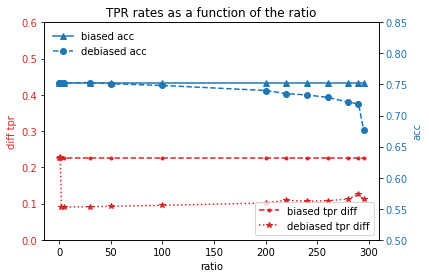

In [32]:
data2plot(plot_results, removel_range)

In [33]:
ratio = 0.7

saved_dataset = np.load(f"../data/saved_models/fair_emoji_sent_race/{ratio}/all.npz")

x_train = saved_dataset['x_train']
y_m_train = saved_dataset['y_m_train']
y_p_train = saved_dataset['y_p_train']
y_p_train_2d = np.asarray([y_p_train, - y_p_train + 1]).T

x_dev = saved_dataset['x_dev']
y_p_dev = saved_dataset['y_p_dev']
y_m_dev = saved_dataset['y_m_dev']

A = np.dot(x_train.T, y_p_train_2d) / x_train.shape[0]
u, s, vh = np.linalg.svd(A, full_matrices=True)
print(f"u has shape {u.shape}, s has shape {s.shape}, vh has shape {vh.shape}")

u has shape (300, 300), s has shape (2,), vh has shape (2, 2)


In [34]:
results = check_result(u, removel_range, x_train, x_dev, y_m_train, y_m_dev, y_p_train, y_p_dev)
results

defaultdict(dict,
            {0: {'p_acc': 0.8199549887471868,
              'biased_diff_tpr': 0.31864557675474753,
              'debiased_diff_tpr': 0.31864557675474753,
              'biased_acc': 0.741185296324081,
              'debiased_acc': 0.741185296324081},
             1: {'p_acc': 0.8438359589897474,
              'biased_diff_tpr': 0.31864557675474753,
              'debiased_diff_tpr': 0.31575482093361984,
              'biased_acc': 0.741185296324081,
              'debiased_acc': 0.7346836709177295},
             2: {'p_acc': 0.463615903975994,
              'biased_diff_tpr': 0.31864557675474753,
              'debiased_diff_tpr': 0.11635856368415173,
              'biased_acc': 0.741185296324081,
              'debiased_acc': 0.7363090772693174},
             5: {'p_acc': 0.46399099774943736,
              'biased_diff_tpr': 0.31864557675474753,
              'debiased_diff_tpr': 0.11674792676509015,
              'biased_acc': 0.741185296324081,
              'deb

In [35]:
plot_results = convert_to_plot_results(results, removel_range)
plot_results

defaultdict(list,
            {'biased_diff_tpr': [0.31864557675474753,
              0.31864557675474753,
              0.31864557675474753,
              0.31864557675474753,
              0.31864557675474753,
              0.31864557675474753,
              0.31864557675474753,
              0.31864557675474753,
              0.31864557675474753,
              0.31864557675474753,
              0.31864557675474753,
              0.31864557675474753,
              0.31864557675474753,
              0.31864557675474753],
             'debiased_diff_tpr': [0.31864557675474753,
              0.31575482093361984,
              0.11635856368415173,
              0.11674792676509015,
              0.12023899899338386,
              0.12100513006482054,
              0.12715509044451567,
              0.15675297512285796,
              0.1525863232511454,
              0.15004721659847078,
              0.1537984908912681,
              0.15392966588017956,
              0.1504312844224986,

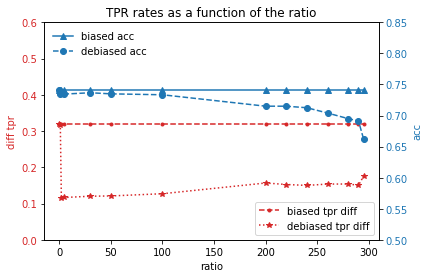

In [36]:
data2plot(plot_results, removel_range)

In [21]:
ratio = 0.8

saved_dataset = np.load(f"../data/saved_models/fair_emoji_sent_race/{ratio}/all.npz")

x_train = saved_dataset['x_train']
y_m_train = saved_dataset['y_m_train']
y_p_train = saved_dataset['y_p_train']
y_p_train_2d = np.asarray([y_p_train, - y_p_train + 1]).T

x_dev = saved_dataset['x_dev']
y_p_dev = saved_dataset['y_p_dev']
y_m_dev = saved_dataset['y_m_dev']

A = np.dot(x_train.T, y_p_train_2d) / x_train.shape[0]
u, s, vh = np.linalg.svd(A, full_matrices=True)
print(f"u has shape {u.shape}, s has shape {s.shape}, vh has shape {vh.shape}")

u has shape (300, 300), s has shape (2,), vh has shape (2, 2)


In [22]:
results = check_result(u, removel_range, x_train, x_dev, y_m_train, y_m_dev, y_p_train, y_p_dev)
results

defaultdict(dict,
            {0: {'p_acc': 0.8379594898724682,
              'biased_diff_tpr': 0.4043010400370602,
              'debiased_diff_tpr': 0.40411721363762787,
              'biased_acc': 0.7200550137534384,
              'debiased_acc': 0.7201800450112528},
             1: {'p_acc': 0.7973243310827707,
              'biased_diff_tpr': 0.4043010400370602,
              'debiased_diff_tpr': 0.3654118278211388,
              'biased_acc': 0.7200550137534384,
              'debiased_acc': 0.7148037009252313},
             2: {'p_acc': 0.47186796699174793,
              'biased_diff_tpr': 0.4043010400370602,
              'debiased_diff_tpr': 0.18610177633438116,
              'biased_acc': 0.7200550137534384,
              'debiased_acc': 0.7191797949487372},
             5: {'p_acc': 0.47199299824956237,
              'biased_diff_tpr': 0.4043010400370602,
              'debiased_diff_tpr': 0.184739631028025,
              'biased_acc': 0.7200550137534384,
              'deb

In [23]:
plot_results = convert_to_plot_results(results, removel_range)
plot_results

defaultdict(list,
            {'biased_diff_tpr': [0.4043010400370602,
              0.4043010400370602,
              0.4043010400370602,
              0.4043010400370602,
              0.4043010400370602,
              0.4043010400370602,
              0.4043010400370602,
              0.4043010400370602,
              0.4043010400370602,
              0.4043010400370602,
              0.4043010400370602,
              0.4043010400370602,
              0.4043010400370602,
              0.4043010400370602],
             'debiased_diff_tpr': [0.40411721363762787,
              0.3654118278211388,
              0.18610177633438116,
              0.184739631028025,
              0.18506971632421484,
              0.1867917631297146,
              0.18737210776237648,
              0.19752038343148395,
              0.202949662154134,
              0.20801803316486164,
              0.18813856463946912,
              0.19263016753347223,
              0.1721118417919755,
              0.0

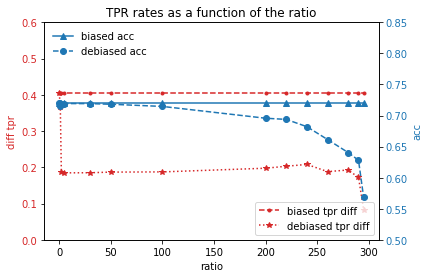

In [24]:
data2plot(plot_results, removel_range)

# Old

In [9]:
removel_range = [0, 1, 2, 5, 30, 50, 100, 200, 220, 240, 260, 280, 290, 295]

In [10]:
ratio = 0.5

x_train, y_p_train, y_m_train = load_data(
    '../data/emoji_sent_race_{}/train/'.format(ratio),
    size=100000, ratio=ratio)
x_dev, y_p_dev, y_m_dev = load_data(
    '../data/emoji_sent_race_{}/test/'.format(ratio),
    size=100000, ratio=0.5)

# y_p_train_2d = np.asarray([y_p_train, y_p_train*-1 +1]).T

# A = np.dot(x_train.T, y_p_train_2d) / x_train.shape[0]
# u, s, vh = np.linalg.svd(A, full_matrices=True)
# print(f"u has shape {u.shape}, s has shape {s.shape}, vh has shape {vh.shape}")

u has shape (300, 300), s has shape (2,), vh has shape (2, 2)


In [11]:
results = check_result(u, removel_range, x_train, x_dev, y_m_train, y_m_dev, y_p_train, y_p_dev)
results

defaultdict(dict,
            {0: {'p_acc': 0.8714678669667417,
              'biased_diff_tpr': 0.14560632483708713,
              'debiased_diff_tpr': 0.14560632483708713,
              'biased_acc': 0.7653163290822705,
              'debiased_acc': 0.7653163290822705},
             1: {'p_acc': 0.8630907726931732,
              'biased_diff_tpr': 0.14560632483708713,
              'debiased_diff_tpr': 0.1445020833238553,
              'biased_acc': 0.7653163290822705,
              'debiased_acc': 0.7653163290822705},
             2: {'p_acc': 0.49699924981245314,
              'biased_diff_tpr': 0.14560632483708713,
              'debiased_diff_tpr': 0.11020173553336259,
              'biased_acc': 0.7653163290822705,
              'debiased_acc': 0.766816704176044},
             5: {'p_acc': 0.4959989997499375,
              'biased_diff_tpr': 0.14560632483708713,
              'debiased_diff_tpr': 0.11007656356661116,
              'biased_acc': 0.7653163290822705,
              

In [14]:
plot_results = convert_to_plot_results(results, removel_range)
plot_results

defaultdict(list,
            {'biased_diff_tpr': [0.14560632483708713,
              0.14560632483708713,
              0.14560632483708713,
              0.14560632483708713,
              0.14560632483708713,
              0.14560632483708713,
              0.14560632483708713,
              0.14560632483708713,
              0.14560632483708713,
              0.14560632483708713,
              0.14560632483708713,
              0.14560632483708713,
              0.14560632483708713,
              0.14560632483708713],
             'debiased_diff_tpr': [0.14560632483708713,
              0.1445020833238553,
              0.11020173553336259,
              0.11007656356661116,
              0.10621266898739956,
              0.10841554967602068,
              0.10844931019709282,
              0.1042793080915506,
              0.09987399516901178,
              0.1032924184615246,
              0.10346416206559751,
              0.1043429019092808,
              0.10178012864537783,


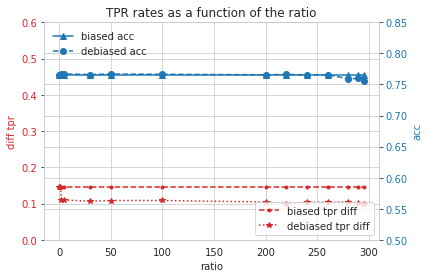

In [15]:
data2plot(plot_results, removel_range)

In [16]:
ratio = 0.6

x_train, y_p_train, y_m_train = load_data(
    '../data/emoji_sent_race_{}/train/'.format(ratio),
    size=100000, ratio=ratio)
x_dev, y_p_dev, y_m_dev = load_data(
    '../data/emoji_sent_race_{}/test/'.format(ratio),
    size=100000, ratio=0.5)

y_p_train_2d = np.asarray([y_p_train, y_p_train*-1 +1]).T

A = np.dot(x_train.T, y_p_train_2d) / x_train.shape[0]
u, s, vh = np.linalg.svd(A, full_matrices=True)
print(f"u has shape {u.shape}, s has shape {s.shape}, vh has shape {vh.shape}")

u has shape (300, 300), s has shape (2,), vh has shape (2, 2)


In [17]:
results = check_result(u, removel_range, x_train, x_dev, y_m_train, y_m_dev, y_p_train, y_p_dev)
results

defaultdict(dict,
            {0: {'p_acc': 0.840960240060015,
              'biased_diff_tpr': 0.22630502371727185,
              'debiased_diff_tpr': 0.22630502371727185,
              'biased_acc': 0.7531882970742686,
              'debiased_acc': 0.7531882970742686},
             1: {'p_acc': 0.8508377094273568,
              'biased_diff_tpr': 0.22630502371727185,
              'debiased_diff_tpr': 0.22803630357189353,
              'biased_acc': 0.7531882970742686,
              'debiased_acc': 0.7530632658164541},
             2: {'p_acc': 0.4711177794448612,
              'biased_diff_tpr': 0.22630502371727185,
              'debiased_diff_tpr': 0.08988024196274066,
              'biased_acc': 0.7531882970742686,
              'debiased_acc': 0.7531882970742686},
             5: {'p_acc': 0.4708677169292323,
              'biased_diff_tpr': 0.22630502371727185,
              'debiased_diff_tpr': 0.09037932830110916,
              'biased_acc': 0.7531882970742686,
              

In [18]:
plot_results = convert_to_plot_results(results, removel_range)
plot_results

defaultdict(list,
            {'biased_diff_tpr': [0.22630502371727185,
              0.22630502371727185,
              0.22630502371727185,
              0.22630502371727185,
              0.22630502371727185,
              0.22630502371727185,
              0.22630502371727185,
              0.22630502371727185,
              0.22630502371727185,
              0.22630502371727185,
              0.22630502371727185,
              0.22630502371727185,
              0.22630502371727185,
              0.22630502371727185],
             'debiased_diff_tpr': [0.22630502371727185,
              0.22803630357189353,
              0.08988024196274066,
              0.09037932830110916,
              0.09126866357639556,
              0.09258461867418033,
              0.09496617559255267,
              0.10150799279833236,
              0.10921997885015855,
              0.10635797301822242,
              0.10776873695187088,
              0.11257271707339944,
              0.125735511715397

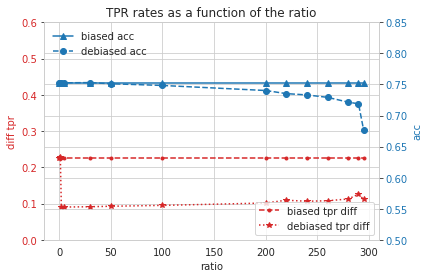

In [19]:
data2plot(plot_results, removel_range)

In [20]:
ratio = 0.7

x_train, y_p_train, y_m_train = load_data(
    '../data/emoji_sent_race_{}/train/'.format(ratio),
    size=100000, ratio=ratio)
x_dev, y_p_dev, y_m_dev = load_data(
    '../data/emoji_sent_race_{}/test/'.format(ratio),
    size=100000, ratio=0.5)

y_p_train_2d = np.asarray([y_p_train, y_p_train*-1 +1]).T

A = np.dot(x_train.T, y_p_train_2d) / x_train.shape[0]
u, s, vh = np.linalg.svd(A, full_matrices=True)
print(f"u has shape {u.shape}, s has shape {s.shape}, vh has shape {vh.shape}")

u has shape (300, 300), s has shape (2,), vh has shape (2, 2)


In [21]:
results = check_result(u, removel_range, x_train, x_dev, y_m_train, y_m_dev, y_p_train, y_p_dev)
results

defaultdict(dict,
            {0: {'p_acc': 0.8199549887471868,
              'biased_diff_tpr': 0.31864557675474753,
              'debiased_diff_tpr': 0.31864557675474753,
              'biased_acc': 0.741185296324081,
              'debiased_acc': 0.741185296324081},
             1: {'p_acc': 0.8438359589897474,
              'biased_diff_tpr': 0.31864557675474753,
              'debiased_diff_tpr': 0.31575482093361984,
              'biased_acc': 0.741185296324081,
              'debiased_acc': 0.7346836709177295},
             2: {'p_acc': 0.463615903975994,
              'biased_diff_tpr': 0.31864557675474753,
              'debiased_diff_tpr': 0.11635856368415173,
              'biased_acc': 0.741185296324081,
              'debiased_acc': 0.7363090772693174},
             5: {'p_acc': 0.46399099774943736,
              'biased_diff_tpr': 0.31864557675474753,
              'debiased_diff_tpr': 0.11674792676509015,
              'biased_acc': 0.741185296324081,
              'deb

In [22]:
plot_results = convert_to_plot_results(results, removel_range)
plot_results

defaultdict(list,
            {'biased_diff_tpr': [0.31864557675474753,
              0.31864557675474753,
              0.31864557675474753,
              0.31864557675474753,
              0.31864557675474753,
              0.31864557675474753,
              0.31864557675474753,
              0.31864557675474753,
              0.31864557675474753,
              0.31864557675474753,
              0.31864557675474753,
              0.31864557675474753,
              0.31864557675474753,
              0.31864557675474753],
             'debiased_diff_tpr': [0.31864557675474753,
              0.31575482093361984,
              0.11635856368415173,
              0.11674792676509015,
              0.12023899899338386,
              0.12100513006482054,
              0.12715509044451567,
              0.15675297512285796,
              0.1525863232511454,
              0.15004721659847078,
              0.1537984908912681,
              0.15392966588017956,
              0.1504312844224986,

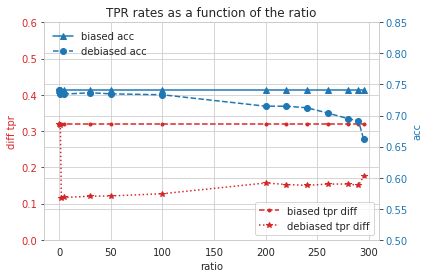

In [23]:
data2plot(plot_results, removel_range)

In [24]:
ratio = 0.8

x_train, y_p_train, y_m_train = load_data(
    '../data/emoji_sent_race_{}/train/'.format(ratio),
    size=100000, ratio=ratio)
x_dev, y_p_dev, y_m_dev = load_data(
    '../data/emoji_sent_race_{}/test/'.format(ratio),
    size=100000, ratio=0.5)

y_p_train_2d = np.asarray([y_p_train, y_p_train*-1 +1]).T

A = np.dot(x_train.T, y_p_train_2d) / x_train.shape[0]
u, s, vh = np.linalg.svd(A, full_matrices=True)
print(f"u has shape {u.shape}, s has shape {s.shape}, vh has shape {vh.shape}")

u has shape (300, 300), s has shape (2,), vh has shape (2, 2)


In [25]:
results = check_result(u, removel_range, x_train, x_dev, y_m_train, y_m_dev, y_p_train, y_p_dev)
results

defaultdict(dict,
            {0: {'p_acc': 0.8379594898724682,
              'biased_diff_tpr': 0.4043010400370602,
              'debiased_diff_tpr': 0.40411721363762787,
              'biased_acc': 0.7200550137534384,
              'debiased_acc': 0.7201800450112528},
             1: {'p_acc': 0.7973243310827707,
              'biased_diff_tpr': 0.4043010400370602,
              'debiased_diff_tpr': 0.3654118278211388,
              'biased_acc': 0.7200550137534384,
              'debiased_acc': 0.7148037009252313},
             2: {'p_acc': 0.47186796699174793,
              'biased_diff_tpr': 0.4043010400370602,
              'debiased_diff_tpr': 0.18610177633438116,
              'biased_acc': 0.7200550137534384,
              'debiased_acc': 0.7191797949487372},
             5: {'p_acc': 0.47199299824956237,
              'biased_diff_tpr': 0.4043010400370602,
              'debiased_diff_tpr': 0.184739631028025,
              'biased_acc': 0.7200550137534384,
              'deb

In [26]:
plot_results = convert_to_plot_results(results, removel_range)
plot_results

defaultdict(list,
            {'biased_diff_tpr': [0.4043010400370602,
              0.4043010400370602,
              0.4043010400370602,
              0.4043010400370602,
              0.4043010400370602,
              0.4043010400370602,
              0.4043010400370602,
              0.4043010400370602,
              0.4043010400370602,
              0.4043010400370602,
              0.4043010400370602,
              0.4043010400370602,
              0.4043010400370602,
              0.4043010400370602],
             'debiased_diff_tpr': [0.40411721363762787,
              0.3654118278211388,
              0.18610177633438116,
              0.184739631028025,
              0.18506971632421484,
              0.1867917631297146,
              0.18737210776237648,
              0.19752038343148395,
              0.202949662154134,
              0.20801803316486164,
              0.18813856463946912,
              0.19263016753347223,
              0.1721118417919755,
              0.0

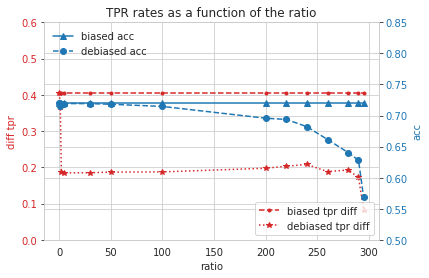

In [27]:
data2plot(plot_results, removel_range)